<a href="https://colab.research.google.com/github/song-pongpanit/human_stress/blob/main/Model_SMS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, roc_curve, roc_auc_score
from sklearn.naive_bayes import BernoulliNB

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Activation,  LayerNormalization, LSTM, MaxPooling1D, Conv1D, Flatten, GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2

import transformers
from transformers import BertTokenizer
from transformers import TFBertModel
from transformers import logging
logging.set_verbosity_warning()

import kerastuner as kt

import warnings
warnings.filterwarnings("ignore")

C:\Users\song-\AppData\Local\Temp\ipykernel_5824\2283927695.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


C:\Users\song-\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\song-\AppData\Local\Temp\ipykernel_5824\2283927695.py:24: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [ ]:
train = pd.read_csv('train_aug4.csv', encoding='latin-1')
test = pd.read_csv('test_aug.csv', encoding='latin-1')
val = pd.read_csv('val_aug.csv', encoding='latin-1')

In [ ]:
train.head()

,Unnamed: 0,text,encoded
0,0,Can you tell Shola to please go to college of ...,0
1,1,Dude im no longer a pisces. Im an aquarius now.,0
2,2,Oh yeah I forgot. U can only take 2 out shoppi...,0
3,3,I hate when she does this. She turns what shou...,0
4,4,", , and picking them up from various points ...",0


# BERT

In [ ]:
train.shape

(5440, 3)

In [ ]:
x_train = train['text']
y_train = train['encoded']
x_val = val['text']
y_val = val['encoded']
x_test = test['text']
y_test = test['encoded']

In [ ]:
max(x_train.apply(lambda x : len(x.split())))

162

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
bert_model.trainable = False

bert_model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109482240 (417.64 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 109482240 (417.64 MB)
_________________________________________________________________


In [ ]:
def bert_encode(data, max_len) :
    input_ids = []
    attention_masks = []
    token_type_ids = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids = True
        )
        input_ids.append(encoded['input_ids'])
        token_type_ids.append(encoded['token_type_ids'])
        attention_masks.append(encoded['attention_mask'])

    return np.array(input_ids), np.array(token_type_ids), np.array(attention_masks)

In [ ]:
max_len = 128

input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
token_type_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
output = bert_model([input_ids, token_type_ids, attention_masks])
output = output # seq(0) , pool(1)
model = Model(inputs =[input_ids, token_type_ids, attention_masks],outputs =output)

def get_embeddings(sentences, max_len = max_len):
    input_ids, token_type_ids, attention_masks = bert_encode(sentences, max_len)
    bert_embs = model.predict([input_ids,token_type_ids,attention_masks])
    return bert_embs

x_train_embs = get_embeddings(x_train)
x_val_embs = get_embeddings(x_val)
x_test_embs = get_embeddings(x_test)

17/17 [==============================] - 36s 2s/step


In [ ]:
x_train_embs[1]

array([[ 0.7332704 ,  0.08774465, -0.56510407, ..., -0.0629632 ,
         0.15925728, -0.66714686],
       [ 0.3071545 , -0.35604528, -0.9685027 , ..., -0.76187277,
        -0.24901502, -0.15901177],
       [ 0.6037735 , -0.0209004 , -0.645115  , ..., -0.13383931,
         0.105645  , -0.26162305],
       ...,
       [ 0.9490656 ,  0.73766637,  0.9898432 , ...,  0.96456856,
         0.7975471 , -0.7744288 ],
       [ 0.9459484 ,  0.80439574,  0.998788  , ...,  0.99221224,
         0.7895805 , -0.8189565 ],
       [ 0.9371354 ,  0.67218727,  0.9570367 , ...,  0.931949  ,
         0.75494206, -0.8472685 ]], dtype=float32)

In [ ]:
x_train_embs[1].shape

(5440, 768)

In [ ]:
x_train_embs[0].shape

(5440, 128, 768)

### dafault DNN V2

In [ ]:
def manual():
  model = Sequential()
  model.add(Input(shape=(x_train_embs[1].shape[1],)))
  model.add(Dense(113, activation='relu'))
  # model.add(Dropout(0.2))
  model.add(Dense(52, activation='relu'))
  # model.add(Dropout(0.1))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer=Adam(learning_rate=0.0026870545264693364), loss='binary_crossentropy', metrics=['accuracy'])
  return model

model = manual()
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,min_delta = 0.0001, restore_best_weights=True)
history = model.fit(x_train_embs[1], y_train, validation_data=(x_val_embs[1], y_val),
                     epochs=81, batch_size=128, callbacks=[early_stop])

Epoch 1/81
43/43 [==============================] - 1s 4ms/step - loss: 0.3609 - accuracy: 0.8474 - val_loss: 0.3976 - val_accuracy: 0.8300
Epoch 2/81
43/43 [==============================] - 0s 3ms/step - loss: 0.2755 - accuracy: 0.8890 - val_loss: 0.2324 - val_accuracy: 0.9045
Epoch 3/81
43/43 [==============================] - 0s 2ms/step - loss: 0.2202 - accuracy: 0.9171 - val_loss: 0.1946 - val_accuracy: 0.9179
Epoch 4/81
43/43 [==============================] - 0s 2ms/step - loss: 0.2111 - accuracy: 0.9199 - val_loss: 0.1758 - val_accuracy: 0.9293
Epoch 5/81
43/43 [==============================] - 0s 2ms/step - loss: 0.1735 - accuracy: 0.9336 - val_loss: 0.1519 - val_accuracy: 0.9427
Epoch 6/81
43/43 [==============================] - 0s 2ms/step - loss: 0.1608 - accuracy: 0.9384 - val_loss: 0.1735 - val_accuracy: 0.9436
Epoch 7/81
43/43 [==============================] - 0s 2ms/step - loss: 0.1627 - accuracy: 0.9364 - val_loss: 0.1590 - val_accuracy: 0.9436
Epoch 8/81
43/43 [==

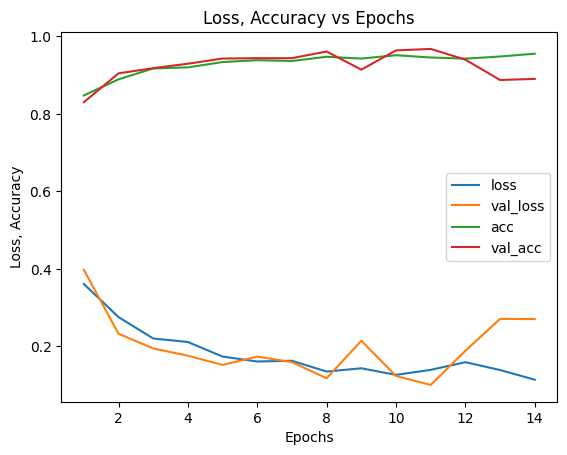

In [ ]:
epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'], label = 'loss')
plt.plot(epochs, history.history['val_loss'], label = 'val_loss')
plt.plot(epochs, history.history['accuracy'], label = 'acc')
plt.plot(epochs, history.history['val_accuracy'], label = 'val_acc')
plt.title('Loss, Accuracy vs Epochs')
plt.xlabel("Epochs")
plt.ylabel("Loss, Accuracy")
plt.legend()
plt.show()

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 113)               86897     
                                                                 
 dense_4 (Dense)             (None, 52)                5928      
                                                                 
 dense_5 (Dense)             (None, 1)                 53        
                                                                 
Total params: 92878 (362.80 KB)
Trainable params: 92878 (362.80 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
loss, acc = model.evaluate(x_train_embs[1], y_train)
print('train acc = ', acc)

170/170 [==============================] - 0s 741us/step - loss: 0.1332 - accuracy: 0.9526
train acc =  0.9525735378265381


In [ ]:
loss, acc = model.evaluate(x_test_embs[1], y_test)
print('test acc = ', acc)

17/17 [==============================] - 0s 896us/step - loss: 0.1561 - accuracy: 0.9490
test acc =  0.9489603042602539


In [ ]:
pred = model.predict(x_test_embs[1], verbose=0)
print('10 True values : {}'.format(y_test.to_list()[:20]))
print('10 Predict values : {} \n'.format([round(x[0]) for x in pred][:20]))
print(classification_report(y_test, [round(x[0]) for x in pred]))

10 True values : [0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
10 Predict values : [0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] 

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       451
           1       0.80      0.87      0.83        78

    accuracy                           0.95       529
   macro avg       0.89      0.92      0.90       529
weighted avg       0.95      0.95      0.95       529



In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score

y_pred = [round(x[0]) for x in pred]
y_true = y_test.to_list()
print(confusion_matrix(y_true, y_pred))
print(accuracy_score(y_true, y_pred))
print(precision_score(y_true, y_pred))
print(recall_score(y_true, y_pred))
print(f1_score(y_true, y_pred))

[[442   9]
 [ 23  55]]
0.9395085066162571
0.859375
0.7051282051282052
0.7746478873239436


### LSTM V2

In [ ]:
def manual_lstm():
  model = Sequential()
  model.add(Input(shape=(x_train_embs[1].shape[1],)))
  model.add(tf.keras.layers.Reshape((1,x_train_embs[1].shape[1])))
  model.add(LSTM(140, activation='relu', dropout= 0, return_sequences= True))
  model.add(LSTM(75, activation='relu'))
  model.add(Dense(125, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer=Adam(learning_rate=0.009929423316917789), loss='binary_crossentropy', metrics=['accuracy'])
  return model

model = manual_lstm()
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,min_delta = 0.0001, restore_best_weights=True)
history = model.fit(x_train_embs[1], y_train, validation_data=(x_val_embs[1], y_val),
                    epochs=20, batch_size=128, callbacks=[early_stop])

In [ ]:
epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'], label = 'loss')
plt.plot(epochs, history.history['val_loss'], label = 'val_loss')
plt.plot(epochs, history.history['accuracy'], label = 'acc')
plt.plot(epochs, history.history['val_accuracy'], label = 'val_acc')
plt.title('Loss, Accuracy vs Epochs')
plt.xlabel("Epochs")
plt.ylabel("Loss, Accuracy")
plt.legend()
plt.show()

In [ ]:
loss, acc = model.evaluate(x_train_embs[1], y_train)
print('train acc = ', acc)

170/170 [==============================] - 0s 1ms/step - loss: 0.3507 - accuracy: 0.8585
train acc =  0.8584558963775635


In [ ]:
loss, acc = model.evaluate(x_test_embs[1], y_test)
print('test acc = ', acc)

17/17 [==============================] - 0s 2ms/step - loss: 0.2813 - accuracy: 0.8828
test acc =  0.8827977180480957


In [ ]:
pred = model.predict(x_test_embs[1], verbose=0)
print('10 True values : {}'.format(y_test.to_list()[:20]))
print('10 Predict values : {} \n'.format([int(np.round(x)) for x in pred][:20]))
print(classification_report(y_test, [int(np.round(x)) for x in pred]))

10 True values : [0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
10 Predict values : [0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1] 

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       451
           1       0.60      0.62      0.61        78

    accuracy                           0.88       529
   macro avg       0.77      0.77      0.77       529
weighted avg       0.88      0.88      0.88       529



### CNN-LSTM V2

In [ ]:
def manual_cnn_ls():
  model = Sequential()
  model.add(Input(shape=(768,1)))

  model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(LSTM(256, return_sequences = True, activation='relu', dropout=0.2))
  model.add(LSTM(128, activation='relu', dropout=0.1))
  model.add(Dense(138, activation='relu'))
  model.add(Dense(115, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer=Adam(learning_rate=0.003), loss='binary_crossentropy', metrics=['accuracy'])
  return model

model = manual_cnn_ls()
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,min_delta = 0.001, restore_best_weights=True)
history = model.fit(np.reshape(x_train_embs[1] , (-1, 768, 1)), y_train,
                    validation_data=(np.reshape(x_val_embs[1], (-1, 768, 1)), y_val),
                    epochs=20, batch_size=128)

In [ ]:
# np.reshape(x_val_embs[1], (-1, 768, 1)).shape

(1047, 768, 1)

In [ ]:
epochs = range(3, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'][2:], label = 'loss')
plt.plot(epochs, history.history['val_loss'][2:], label = 'val_loss')
plt.plot(epochs, history.history['accuracy'][2:], label = 'acc')
plt.plot(epochs, history.history['val_accuracy'][2:], label = 'val_acc')
plt.title('Loss, Accuracy vs Epochs')
plt.xlabel("Epochs")
plt.ylabel("Loss, Accuracy")
plt.legend()
plt.show()

In [ ]:
loss, acc = model.evaluate(np.reshape( x_train_embs[1], (-1, 768, 1) ), y_train)
print('train acc = ', acc)

170/170 [==============================] - 6s 37ms/step - loss: 0.6931 - accuracy: 0.5000
train acc =  0.5


In [ ]:
loss, acc = model.evaluate(np.reshape( x_test_embs[1] , (-1, 768, 1) ), y_test)
print('test acc = ', acc)

17/17 [==============================] - 1s 36ms/step - loss: 0.6955 - accuracy: 0.1474
test acc =  0.14744801819324493


In [ ]:
pred = model.predict(x_test_embs[1], verbose=0)
print('10 True values : {}'.format(y_test.to_list()[:20]))
print('10 Predict values : {} \n'.format([int(np.round(x)) for x in pred][:20]))
print(classification_report(y_test, [int(np.round(x)) for x in pred], output_dict=True))

10 True values : [0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
10 Predict values : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] 

{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 451.0}, '1': {'precision': 0.14744801512287334, 'recall': 1.0, 'f1-score': 0.257001647446458, 'support': 78.0}, 'accuracy': 0.14744801512287334, 'macro avg': {'precision': 0.07372400756143667, 'recall': 0.5, 'f1-score': 0.128500823723229, 'support': 529.0}, 'weighted avg': {'precision': 0.021740917163675086, 'recall': 0.14744801512287334, 'f1-score': 0.0378943827992887, 'support': 529.0}}


### Hyperband DNN

In [ ]:
def hb_dnn(hp):
    model = Sequential()
    model.add(Input(shape=(768,)))
    for i in range(hp.Int("num_layers", min_value=1, max_value=3)):
      model.add(Dense(units=hp.Int("units_" + str(i), min_value=32, max_value=256, step=1),
                      activation='relu'))
      model.add(Dropout(hp.Float("dropout_" + str(i), 0, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    # compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float("lr", 1e-4, 1e-2, sampling ='log')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
# Instantiate the tuner
tuner = kt.Hyperband(hb_dnn,
                     objective="val_loss",
                     max_epochs=81,
                     factor=3,
                     directory="kt_dnn_4",
                     project_name="kt_hyperband",
                     seed = 101)

# Display search space summary
tuner.search_space_summary()

Reloading Tuner from kt_dnn_4\kt_hyperband\tuner0.json
Search space summary
Default search space size: 8
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 1, 'sampling': 'linear'}
dropout_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 1, 'sampling': 'linear'}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 1, 'sampling': 'linear'}
dropout_2 (Float)
{'default': 0.0, 'conditions': [], 

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,
                                              min_delta = 0.001, restore_best_weights=True)

tuner.search(x_train_embs[1], y_train, validation_data=(x_val_embs[1], y_val),
             epochs=20, batch_size=128, callbacks=[early_stop], verbose=2)

In [ ]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters()[0]
print('units_0 = ', best_hps.get('units_0'))
print('units_1 = ', best_hps.get('units_1'))
print('units_2 = ', best_hps.get('units_2'))
print('lr = ', best_hps.get('lr'))
print('num_layers = ', best_hps.get('num_layers'))
print('dropout_0 = ', best_hps.get('dropout_0'))
print('dropout_1 = ', best_hps.get('dropout_1'))
print('dropout_2 = ', best_hps.get('dropout_2'))

units_0 =  113
units_1 =  52
units_2 =  233
lr =  0.0026870545264693364
num_layers =  2
dropout_0 =  0.0
dropout_1 =  0.0
dropout_2 =  0.30000000000000004


In [ ]:
best_dnn = tuner.get_best_models()[0]
print(best_dnn.evaluate(x_test_embs[1], y_test))

17/17 [==============================] - 0s 1ms/step - loss: 0.1231 - accuracy: 0.9509
[0.12314346432685852, 0.9508506655693054]


In [ ]:
best_dnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 113)               86897     
                                                                 
 dropout (Dropout)           (None, 113)               0         
                                                                 
 dense_1 (Dense)             (None, 52)                5928      
                                                                 
 dropout_1 (Dropout)         (None, 52)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 53        
                                                                 
Total params: 92878 (362.80 KB)
Trainable params: 92878 (362.80 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
best_dnn_pred = best_dnn.predict(x_test_embs[1], verbose=0)
print('10 True values : {}'.format(y_test.to_list()[:20]))
print('10 Predict values : {} \n'.format([round(x[0]) for x in best_dnn_pred][:20]))
print(classification_report(y_test, [round(x[0]) for x in best_dnn_pred], output_dict=True))

10 True values : [0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
10 Predict values : [0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] 

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       451
           1       0.85      0.81      0.83        78

    accuracy                           0.95       529
   macro avg       0.91      0.89      0.90       529
weighted avg       0.95      0.95      0.95       529



### Hyperband LSTM

In [ ]:
def hb_lstm(hp):
    model = Sequential()
    model.add(Input(shape=(768,)))
    model.add(tf.keras.layers.Reshape((1,768)))
    model.add(LSTM(hp.Int("units_start", min_value=128, max_value=256, step=1), activation='relu', return_sequences = True,
                   dropout= hp.Float("dropout_lstm1", 0, 0.5, step=0.1)))
    model.add(LSTM(hp.Int("units_lstm", min_value=64, max_value=128, step=1), activation='relu',
                   dropout= hp.Float("dropout_lstm2", 0, 0.5, step=0.1)))
    for i in range(hp.Int("num_layers", min_value=1, max_value=3)):
      model.add(Dense(units=hp.Int("units_dense_" + str(i), min_value=32, max_value=128, step=1),
                      activation='relu'))
      model.add(Dropout(hp.Float("dropout_" + str(i), 0, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    # compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float("lr", 1e-4, 1e-2, sampling ='log')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
# Instantiate the tuner
tuner1 = kt.Hyperband(hb_lstm,
                     objective="val_loss",
                     max_epochs=81,
                     factor=3,
                     directory="kt_lstm_4_1",
                     project_name="kt_hyperband",
                     seed = 101)

# Display search space summary
tuner1.search_space_summary()

Reloading Tuner from kt_lstm_4_1\kt_hyperband\tuner0.json
Search space summary
Default search space size: 12
units_start (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 1, 'sampling': 'linear'}
dropout_lstm1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
units_lstm (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 128, 'step': 1, 'sampling': 'linear'}
dropout_lstm2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_dense_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 1, 'sampling': 'linear'}
dropout_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
lr (Float)
{'default': 0.

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,
                                              min_delta = 0.001, restore_best_weights=True)

tuner1.search(x_train_embs[1], y_train, validation_data=(x_val_embs[1], y_val),
             epochs=20, batch_size=128, callbacks=[early_stop], verbose=2)

In [ ]:
# Get the optimal hyperparameters
best_lstm_hps=tuner1.get_best_hyperparameters()[0]
print('units_start = ', best_lstm_hps.get('units_start'))
print('dropout_lstm1 = ', best_lstm_hps.get('dropout_lstm1'))
print('units_lstm = ', best_lstm_hps.get('units_lstm'))
print('dropout_lstm2 = ', best_lstm_hps.get('dropout_lstm2'))
print('num_layers = ', best_lstm_hps.get('num_layers'))
print('units_dense_0 = ', best_lstm_hps.get('units_dense_0'))
print('dropout_0 = ', best_lstm_hps.get('dropout_0'))
print('lr = ', best_lstm_hps.get('lr'))
print('units_dense_1 = ', best_lstm_hps.get('units_dense_1'))
print('units_dense_1 = ', best_lstm_hps.get('dropout_1'))
print('units_dense_2 = ', best_lstm_hps.get('units_dense_1'))
print('units_dense_2 = ', best_lstm_hps.get('dropout_1'))


units_start =  140
dropout_lstm1 =  0.0
units_lstm =  75
dropout_lstm2 =  0.30000000000000004
num_layers =  3
units_dense_0 =  116
dropout_0 =  0.30000000000000004
lr =  0.0016274878533905327
units_dense_1 =  127
units_dense_1 =  0.0
units_dense_2 =  127
units_dense_2 =  0.0


In [ ]:
best_lstm = tuner1.get_best_models()[0]
print(best_lstm.evaluate(x_test_embs[1], y_test))




17/17 [==============================] - 1s 2ms/step - loss: 0.1400 - accuracy: 0.9452
[0.13996852934360504, 0.9451795816421509]


In [ ]:
best_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1, 768)            0         
                                                                 
 lstm (LSTM)                 (None, 1, 140)            509040    
                                                                 
 lstm_1 (LSTM)               (None, 75)                64800     
                                                                 
 dense (Dense)               (None, 116)               8816      
                                                                 
 dropout (Dropout)           (None, 116)               0         
                                                                 
 dense_1 (Dense)             (None, 127)               14859     
                                                                 
 dropout_1 (Dropout)         (None, 127)               0

In [ ]:
model = tuner1.hypermodel.build(best_lstm_hps)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,min_delta = 0.001, restore_best_weights=True)
history = model.fit(x_train_embs[1], y_train, validation_data=(x_val_embs[1], y_val),
                    epochs=20, batch_size=128, callbacks=[early_stop])

Epoch 1/20
43/43 [==============================] - 2s 14ms/step - loss: 0.4085 - accuracy: 0.8259 - val_loss: 0.2672 - val_accuracy: 0.8797
Epoch 2/20
43/43 [==============================] - 0s 7ms/step - loss: 0.3269 - accuracy: 0.8708 - val_loss: 0.3023 - val_accuracy: 0.8653
Epoch 3/20
43/43 [==============================] - 0s 6ms/step - loss: 0.2859 - accuracy: 0.8816 - val_loss: 0.2251 - val_accuracy: 0.8959
Epoch 4/20
43/43 [==============================] - 0s 8ms/step - loss: 0.2597 - accuracy: 0.8974 - val_loss: 0.3578 - val_accuracy: 0.8443
Epoch 5/20
43/43 [==============================] - 0s 6ms/step - loss: 0.2360 - accuracy: 0.9108 - val_loss: 0.1892 - val_accuracy: 0.9322
Epoch 6/20
43/43 [==============================] - 0s 7ms/step - loss: 0.2198 - accuracy: 0.9191 - val_loss: 0.1770 - val_accuracy: 0.9351
Epoch 7/20
43/43 [==============================] - 0s 6ms/step - loss: 0.2031 - accuracy: 0.9241 - val_loss: 0.1841 - val_accuracy: 0.9293
Epoch 8/20
43/43 [=

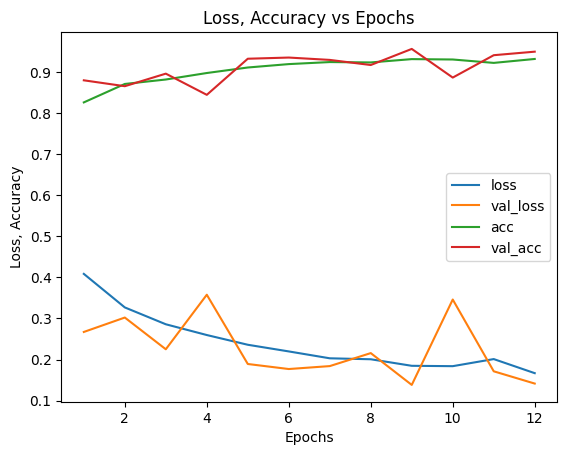

In [ ]:
epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'], label = 'loss')
plt.plot(epochs, history.history['val_loss'], label = 'val_loss')
plt.plot(epochs, history.history['accuracy'], label = 'acc')
plt.plot(epochs, history.history['val_accuracy'], label = 'val_acc')
plt.title('Loss, Accuracy vs Epochs')
plt.xlabel("Epochs")
plt.ylabel("Loss, Accuracy")
plt.legend()
plt.show()

In [ ]:
best_lstm_pred = best_lstm.predict(x_test_embs[1], verbose=0)
print('10 True values : {}'.format(y_test.to_list()[:20]))
print('10 Predict values : {} \n'.format([round(x[0]) for x in best_lstm_pred][:20]))
print(classification_report(y_test, [round(x[0]) for x in best_lstm_pred], output_dict=True))

10 True values : [0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
10 Predict values : [0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] 

{'0': {'precision': 0.9668141592920354, 'recall': 0.9689578713968958, 'f1-score': 0.9678848283499446, 'support': 451.0}, '1': {'precision': 0.8181818181818182, 'recall': 0.8076923076923077, 'f1-score': 0.8129032258064516, 'support': 78.0}, 'accuracy': 0.945179584120983, 'macro avg': {'precision': 0.8924979887369269, 'recall': 0.8883250895446018, 'f1-score': 0.890394027078198, 'support': 529.0}, 'weighted avg': {'precision': 0.9448986156122681, 'recall': 0.945179584120983, 'f1-score': 0.9450330986743445, 'support': 529.0}}


In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score

y_pred = [round(x[0]) for x in best_lstm_pred]
y_true = y_test.to_list()
print(confusion_matrix(y_true, y_pred))
print(accuracy_score(y_true, y_pred))
print(precision_score(y_true, y_pred))
print(recall_score(y_true, y_pred))
print(f1_score(y_true, y_pred))

[[437  14]
 [ 15  63]]
0.945179584120983
0.8181818181818182
0.8076923076923077
0.8129032258064516


### Hyperband CNN+LSTM

In [ ]:
def hb_cnn_lstm(hp):
    model = Sequential()
    model.add(Input(shape=(768,1)))
    model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(hp.Int("units_start", min_value=128, max_value=256), activation='relu', return_sequences = True,
                   dropout= hp.Float("dropout_lstm1", 0, 0.5, step=0.1)))
    model.add(LSTM(hp.Int("units_lstm_base", min_value=32, max_value=128), activation='relu',
                   dropout= hp.Float("dropout_lstm2", 0, 0.5, step=0.1)))
    for i in range(hp.Int("num_layers", min_value=1, max_value=2)):
      model.add(Dense(units=hp.Int("units_dense_" + str(i), min_value=32, max_value=64),
                      activation='relu'))
      model.add(Dropout(hp.Float("dropout_" + str(i), 0, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))


    # compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float("lr", 1e-4, 1e-2, sampling ='log')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
# Instantiate the tuner
tuner2 = kt.Hyperband(hb_cnn_lstm,
                     objective="val_loss",
                     max_epochs=81,
                     factor=3,
                     directory="kt_comb_4_1",
                     project_name="kt_hyperband",
                     seed = 101)

# Display search space summary
tuner2.search_space_summary()

Reloading Tuner from kt_comb_4_1\kt_hyperband\tuner0.json
Search space summary
Default search space size: 10
units_start (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 1, 'sampling': 'linear'}
dropout_lstm1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
units_lstm_base (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 1, 'sampling': 'linear'}
dropout_lstm2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
units_dense_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 1, 'sampling': 'linear'}
dropout_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
lr (Float)
{'default'

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,
                                              min_delta = 0.001, restore_best_weights=True)

tuner2.search(np.reshape( x_train_embs[1] , (-1, 768, 1) ), y_train,
              validation_data=(np.reshape( x_val_embs[1] , (-1, 768, 1) ), y_val),
             epochs=20, batch_size=128, callbacks=[early_stop], verbose=2)

In [ ]:
# Get the optimal hyperparameters
best_lstm_hps=tuner2.get_best_hyperparameters()[0]
print('units_start = ', best_lstm_hps.get('units_start'))
print('dropout_lstm1 = ', best_lstm_hps.get('dropout_lstm1'))
print('units_lstm_base = ', best_lstm_hps.get('units_lstm_base'))
print('dropout_lstm2 = ', best_lstm_hps.get('dropout_lstm2'))
print('num_layers = ', best_lstm_hps.get('num_layers'))
print('lr = ', best_lstm_hps.get('lr'))
print('units_dense_0 = ', best_lstm_hps.get('units_dense_0'))
print('dropout_0 = ', best_lstm_hps.get('dropout_0'))
print('units_dense_1 = ', best_lstm_hps.get('units_dense_1'))
print('dropout_1 = ', best_lstm_hps.get('dropout_1'))

units_start =  180
dropout_lstm1 =  0.0
units_lstm_base =  83
dropout_lstm2 =  0.2
num_layers =  2
lr =  0.0009597364113807246
units_dense_0 =  47
dropout_0 =  0.4
units_dense_1 =  39
dropout_1 =  0.0


In [ ]:
best_comb = tuner2.get_best_models()[0]
print(best_comb.evaluate(x_test_embs[1], y_test))

17/17 [==============================] - 1s 25ms/step - loss: 0.1585 - accuracy: 0.9395
[0.15848462283611298, 0.9395084977149963]


In [ ]:
best_comb.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 768, 128)          512       
                                                                 
 max_pooling1d (MaxPooling1  (None, 384, 128)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 384, 64)           24640     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 192, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 192, 32)           6176      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 96, 32)            0

In [ ]:
best_comb_pred = best_comb.predict(x_test_embs[1], verbose=0)
print('10 True values : {}'.format(y_test.to_list()[:20]))
print('10 Predict values : {} \n'.format([round(x[0]) for x in best_comb_pred][:20]))
print(classification_report(y_test, [round(x[0]) for x in best_comb_pred], output_dict=True))

10 True values : [0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
10 Predict values : [0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] 

{'0': {'precision': 0.9707865168539326, 'recall': 0.9578713968957872, 'f1-score': 0.9642857142857143, 'support': 451.0}, '1': {'precision': 0.7738095238095238, 'recall': 0.8333333333333334, 'f1-score': 0.8024691358024691, 'support': 78.0}, 'accuracy': 0.9395085066162571, 'macro avg': {'precision': 0.8722980203317282, 'recall': 0.8956023651145603, 'f1-score': 0.8833774250440918, 'support': 529.0}, 'weighted avg': {'precision': 0.9417426502046625, 'recall': 0.9395085066162571, 'f1-score': 0.9404261809743852, 'support': 529.0}}


In [ ]:
model = tuner2.hypermodel.build(best_lstm_hps)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,min_delta = 0.001, restore_best_weights=True)
history = model.fit(x_train_embs[1], y_train, validation_data=(x_val_embs[1], y_val),
                    epochs=20, batch_size=128, callbacks=[early_stop])

Epoch 1/20
43/43 [==============================] - 12s 228ms/step - loss: 1215.1705 - accuracy: 0.5335 - val_loss: 0.6643 - val_accuracy: 0.8539
Epoch 2/20
43/43 [==============================] - 10s 222ms/step - loss: 286.9260 - accuracy: 0.5618 - val_loss: 0.6666 - val_accuracy: 0.8539
Epoch 3/20
43/43 [==============================] - 9s 221ms/step - loss: 6.4465 - accuracy: 0.6265 - val_loss: 0.5950 - val_accuracy: 0.8539
Epoch 4/20
43/43 [==============================] - 9s 220ms/step - loss: 0.6935 - accuracy: 0.5156 - val_loss: 0.7043 - val_accuracy: 0.1461
Epoch 5/20
43/43 [==============================] - 9s 221ms/step - loss: 0.9696 - accuracy: 0.6307 - val_loss: 0.6099 - val_accuracy: 0.8539
Epoch 6/20
43/43 [==============================] - 10s 222ms/step - loss: 0.6666 - accuracy: 0.6307 - val_loss: 0.6047 - val_accuracy: 0.7679


In [ ]:
epochs = range(3, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'][3:], label = 'loss')
plt.plot(epochs, history.history['val_loss'][3:], label = 'val_loss')
plt.plot(epochs, history.history['accuracy'][3:], label = 'acc')
plt.plot(epochs, history.history['val_accuracy'][3:], label = 'val_acc')
plt.title('Loss, Accuracy vs Epochs')
plt.xlabel("Epochs")
plt.ylabel("Loss, Accuracy")
plt.legend()
plt.show()